### Eigenvalue Preparation

Author: Roberto Hernández Palomares, Date: 15 June, 2025

Input: an oracular black-box unitary $U$ on $n$ qubits with pairwise distinct eigenvalues $\{e^{i2\pi\Theta(x)}\}_{x\in \mathbb{F}_2^n}$. A number $t\in[0,1]$ with the property that there exists a unique $x_0 = x_0(t)$ such that $e^{i2\pi\Theta(x_0)} = e^{i2\pi t}$. Finally, $d\in\mathbb{N}$ such that for all $x$, $2^d\Theta(x)\in \mathbb{Z}.$

Te goal is to find $|x_0\rangle$ up to $O(2^{-n})$-error with high probability.

Method:

   1.- We first use Quantum Phase Estimation to 'mark $x_0$'
    
   2.- Use Grover's algorithm to approximate it. 

We first gather all the packages to be used and the Quantum Fourier Transform.

In [597]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit import transpile
from qiskit.circuit.library.standard_gates import HGate
#from qiskit.circuit.library.DiagonalGate import Diag

import numpy as np
import math
import cmath
from math import e

# We copy QFT^\dag from Notebook 3
def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)

    return inverse_QFT_circuit.to_gate()


### Step1: We implement the $\textbf{Quantum Phase Estimation}$ process to mark $x_0$.

Set input parameters:

In [600]:
### Set your parameters
n = 4 # Number of Qubits U operates on
d = 3 # Precision parameter
t = 0.6595

We now build some oracular diagonal $U$ acting on $n$ qubits with random eigenvalues:

In [602]:
### Creating some unitary U on n qubits randomly
U_bits = list(range(0,n))
U_qr = QuantumRegister(n, 'x')
U_qc = QuantumCircuit(U_qr, name = 'oracleU')
U_vals = [ complex(0, 0) for k in range(2**n) ] 

aux = 0
for i in range(2**n):
    aux = np.random.rand()
    U_vals[i] = e**(0+aux*np.pi*2j)

U = Diagonal(U_vals) ### Notice likelyhood of having repeated eigenvalues is quite low, so we go with this. 
U_qc.compose(U, inplace=True)

U_oracle = U_qc.to_gate()
#U_qc.draw(output='mpl')

Preparing Quantum Phase Estimation Circuit in order to digitize $\Theta(x_0)$ corresponding to $t$ with $d$ bits.

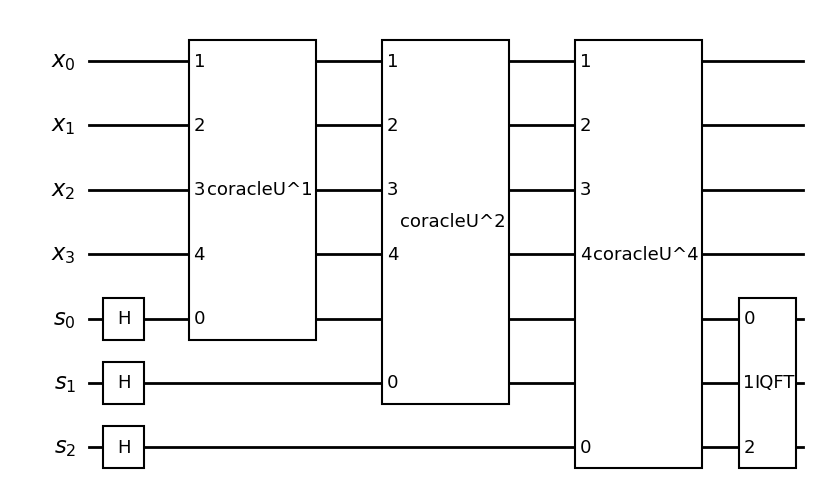

In [604]:
QPE_bits = list(range(0, n))
QPE_qr = QuantumRegister(n, 'x')
QPE_ANbits = list(range(n, n+d))
QPEan_qr = AncillaRegister(d, 's')
QPE_qc = QuantumCircuit(QPE_qr, QPEan_qr, name ='QPE')

CU_oracle = U_oracle.control(1)

QPE_qc.h(QPEan_qr)

aux = QPE_bits+[n-1]
for i in range(0,n):
    aux[i+1] = i 

for i, q in enumerate(QPEan_qr):
    aux[0] = q
    #QPE_qc.append(CU_oracle**(2**i), [q,0,1,2])
    QPE_qc.append(CU_oracle**(2**i), aux)

QPE_qc.append(inverse_quantum_fourier_transform(d), QPE_ANbits)

QPE = QPE_qc.to_gate()
QPE_qc.draw(output='mpl', style = 'bw')

In [605]:
output_state = Statevector(QPE_qc)
output_state.draw("latex")

<IPython.core.display.Latex object>

### We now construct a  $\textbf{diagonal Unitary for Grover's Algorithm}$, implementing a gate $U_{Grov}$ having $x_0$ as eigenvector for $-1$ and acting as the identity over the perp. 

In [607]:
# Construction of qubits, ancillas and Grovner circuit
Grov_bits = list(range(0, n))
Grov_ANbits = list(range(n, n+d))
Grov_qr = QuantumRegister(n, 'x')
Grov_ANqr = AncillaRegister(d, 's')
Grov_qc = QuantumCircuit(Grov_qr, Grov_ANqr, name ='QPE')

U_Grov_qc = QuantumCircuit(Grov_qr, Grov_ANqr, name="Marker U")

### We now construct an auxiliary function that gives the best binary approximation of $t$ using $d$ bits, and build a gate which complements it to the binary expression of $2^{d-1}$.

t_bits= [1 0 1] 



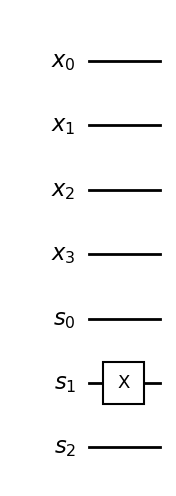

In [609]:

# We now obtain the digits of t that best approximate it using d bits
t_bits = (int(np.rint(2**d * t)) >> np.arange(d))%2 #np.rint() rounds to nearest integer
print('t_bits=', t_bits, '\n')

Complement_bits = list(range(0, n))
Complement_qr = QuantumRegister(n, 'x')
Complement_ANqr = AncillaRegister(d, 's')
Complement_qc = QuantumCircuit(Complement_qr, Complement_ANqr, name ='t-digComp')

for a in range(0, d):#Ensuring turning t_bit[a] into 1
    if t_bits[a] == 0:
        #print(a, t_bits[a])
        Complement_qc.x(n+a)

U_complement = Complement_qc.to_gate()

Complement_qc.draw(output='mpl', style='bw')

### We now build a $d\textbf{-dimensional multi-controlled-}Z^d$ gate:

In [611]:
mcZd_bits = list(range(0, n))
mcZd_ANbits = list(range(n, n+d))
mcZd_qr = QuantumRegister(n, 'x')
mcZdAN_qr = AncillaRegister(d, 's')
mcZd_qc = QuantumCircuit(mcZd_qr, mcZdAN_qr, name =r"$C^dZ^{\otimes d}$")

for b in range(0, n):
    mcZd_qc.mcp(np.pi, Grov_ANbits, Grov_qr[b])

CdZd = mcZd_qc.to_gate()

### We now compose all these pieces together as follows:
$$
U_{Grov, t}:= (QPE)^\dagger\circ\left((X)^{\otimes(1-t_{bits})}\right)^\dagger\circ(C^dZ^{\otimes d})\circ(X)^{\otimes(1-t_{bits})}\circ(QPE).
$$
A direct computation shows that 
$$
U_{Grov,t}:\sum_{x\in \mathbb{F}^2}|x\rangle|0\rangle_d\mapsto \sum_{x\in \mathbb{F}^2\setminus\{t\}}|x\rangle|0\rangle_d - |t\rangle|0\rangle_d, 
$$
thus capturing the desired 'marker' unitary to run Grover's Algorithm. 

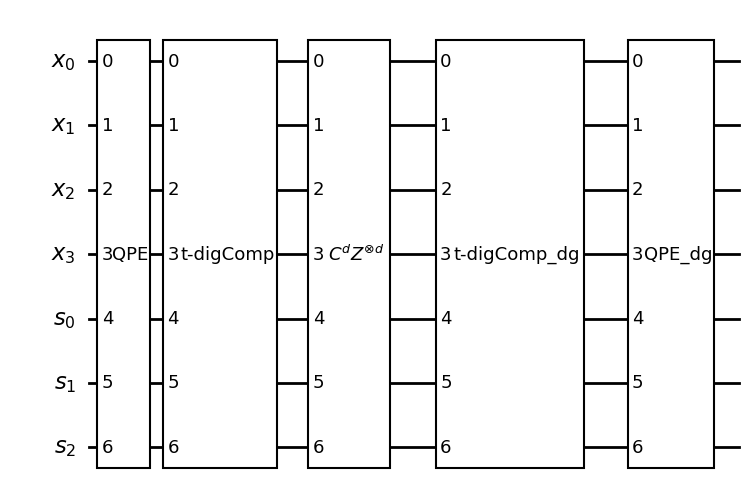

In [613]:
U_Grov_qc.compose(QPE, inplace = True)
U_Grov_qc.compose(U_complement, inplace=True)    #Complement of t 
U_Grov_qc.compose(CdZd, inplace=True)   # mcZ^d gate
U_Grov_qc.compose(U_complement.inverse(), inplace=True)   #complement of t
U_Grov_qc.compose(QPE.inverse(), inplace = True)


Marker = U_Grov_qc.to_gate()
U_Grov_qc.draw(output='mpl', style='bw')

### Grover's Diffusion operator

In [615]:
Diff_bits = list(range(0,n))
Diff_Anbits = list(range(n, n+d))
Diff_qr = QuantumRegister(n, 'x')
Diff_ANqr = AncillaRegister(d, 's')
Diff_qc = QuantumCircuit(Diff_qr, Diff_ANqr, name = 'Diffuser')


D_vals = -1*np.ones(2**(n+d)) ## this is the operator 2|0><0|-\id_2^{\otimes n}
D_vals[0] = 1
D = np.diag(D_vals)
D_bits = list(range(0, n+d))



######## Diffuse operator
Diff_qc.h(Diff_qr)
Diff_qc.h(Diff_ANqr)

## Implementing H^{\otimes n} \circ (2|0><0| - \id_2^{\otimes n}) \circ H^{\otimes n}.
## Notice (2|0><0| - \id_2^{\otimes n}) = diag(-1, 1, 1, ..., 1) in comp basis.
Diff_qc.unitary(D, qubits=D_bits)

Diff_qc.h(Diff_qr)
Diff_qc.h(Diff_ANqr)
##########

Diffuser = Diff_qc.to_gate()
#Diff_qc.draw(output='mpl')

### Circuit for Grover's Algorithm using $U_{Grov, t}$ 

3


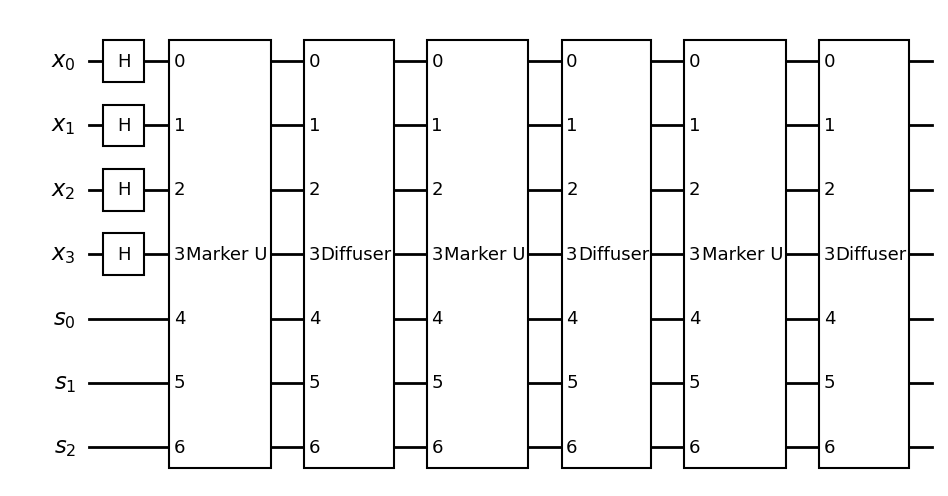

In [617]:
# Let's construct Grover's Algorithm Circuit
GAC_bits = list(range(0, n))
GAC_ANbits = list(range(n, n+d))
GAC_qr = QuantumRegister(n, 'x')
GAC_ANqr = AncillaRegister(d, 's')
GAC_qc = QuantumCircuit(Grov_qr, Grov_ANqr, name ='Grover`s')

K = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(2**n))) - 1/2))
print(K)

### We now iterate U_Grov \circ Diffuser K times:
GAC_qc.h(GAC_qr)
for i in range(0, K):
    GAC_qc.compose(Marker, inplace=True)
    GAC_qc.compose(Diffuser, inplace=True)

GAC = GAC_qc.to_gate()
GAC_qc.draw(output='mpl', style='bw')

In [618]:
psi = Statevector(GAC)
psi.probabilities()

array([5.38137157e-02, 5.37321507e-02, 4.03998277e-02, 5.38137157e-02,
       7.53227161e-02, 5.38137157e-02, 5.38137157e-02, 5.31010754e-02,
       2.79200541e-02, 5.38137157e-02, 5.38137157e-02, 5.16718395e-03,
       5.38137157e-02, 2.09900779e-02, 4.05189499e-02, 5.38137157e-02,
       3.27473907e-04, 4.04284321e-04, 7.05725502e-04, 3.27473907e-04,
       1.17215616e-03, 3.27473907e-04, 3.27473907e-04, 4.52575288e-04,
       2.52732169e-03, 3.27473907e-04, 3.27473907e-04, 3.03713172e-03,
       3.27473907e-04, 1.17319747e-03, 5.24390494e-04, 3.27473907e-04,
       3.27473907e-04, 2.44602746e-03, 3.30432931e-03, 3.27473907e-04,
       3.82394252e-03, 3.27473907e-04, 3.27473907e-04, 2.86885049e-03,
       9.39426762e-03, 3.27473907e-04, 3.27473907e-04, 1.10376697e-02,
       3.27473907e-04, 3.57555726e-03, 1.04633484e-03, 3.27473907e-04,
       3.27473907e-04, 1.19293648e-03, 1.48961086e-04, 3.27473907e-04,
       2.12123591e-04, 3.27473907e-04, 3.27473907e-04, 9.96873842e-04,
      